# **CRISP-DM — Portfolio & Long-Lived Series (PS3→PS4→PS5)**

## **Step 1: Business Understanding**

---

### **Problem**
The goal will be to study the differences in game performance and sequel performance across multiple PlayStation console generations and select the publishers who display the highest levels of long-term stability from the `PlayStationSales.csv` file.

### **Main Questions**
- Q1: What impact do sequels have when switching from `PS3` to `PS4` and then to the `PS5`?
- Q2: Which publishers provide `consistent results` over the years and across
different consoles?

### **Objectives**
- Developing a series performance index using `Total Sales` normalized across each `Console & Year`.
- Measure sequel delta (Part `N+1` - Part `N`) and study the jump effect (`PS3 → PS4`, `PS4 → PS5`).
- Order the publishers based on their `level of stability`, which can be measured as their ability to perform well and remain consistent over time.

### **Success Criteria**
- Analysis of at least `10` series with `3 or more` entries.
- List of the `top 10` publishers according to the measure of stability through its high median value and low dispersion.
- Presence of at least `5` visualizations that support the findings.

### **Scope**

**In:**
- Released games available through the consoles mentioned in the Console column, mostly the `PS3`, `PS4`, and `PS5`.
- Fields: Name, Publisher, Developer, Release Date, Total Sales, and regional sales (NA Sales, PAL Sales, Japan Sales, Other Sales).
- Inferred series/franchise and part number from `Name` and `Release Date`.

**Out:**
- Precise unit predictions or cause inferences that lie beyond observed instances.
- Other platforms than the `PlayStation` family.

### **Data**
- Game title: `Name`
- Console / generation: `Console`
- Publisher: `Publisher`
- Developer: `Developer`
- Release date and year: `Release Date` → `Year`
- Performance: `Total Sales` and regional sales columns
- Extra metadata (genres, modes, etc.) if needed for context


## **Step 2: Data Understanding**

---

### **What we do here**
- Load `PlayStationSales.csv`.
- Parse `Release Date` into a new `Year` column.
- Use the `Console`, `Publisher`, `Total Sales` and regional sales columns.
- Perform basic exploratory analysis (counts, totals, distributions) across consoles and years.
- Build quick views to understand the overall shape and coverage of the dataset.

### **Key views**
- Releases by console and year  
  Line chart: `Year` on X, number of games on Y, separate lines for each value in `Console` (for example `PS3`, `PS4`, `PS5`).
- Total sales by year  
  Line chart: `Year` on X, sum of `Total Sales` on Y.
- Top publishers by activity  
  Horizontal bar chart: top publishers by total `Total Sales` or by number of games.

### **Notes**
- Rows with missing `Release Date` (and so missing `Year`) are removed.
- The focus is on PlayStation consoles in the `Console` column (mainly `PS3`, `PS4`, `PS5`).
- Data after `2018` has very low or zero `Total Sales`, so later analysis may focus on years where sales data is complete.
- We explicitly record these data quality issues (missing dates, incomplete sales in recent years) as limitations for later steps.
- This step is only about structure and distributions, not yet about the Series Performance Index or sequel analysis.


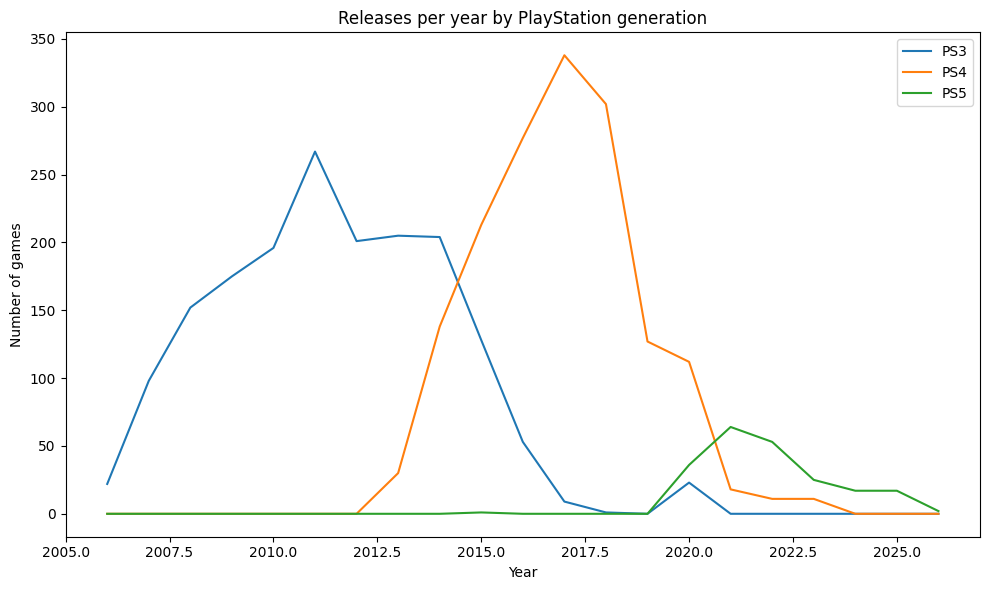

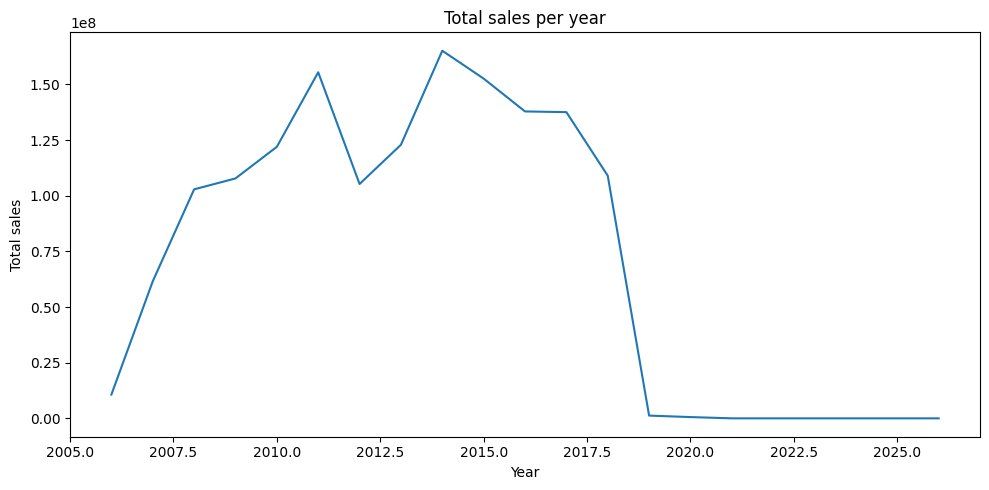

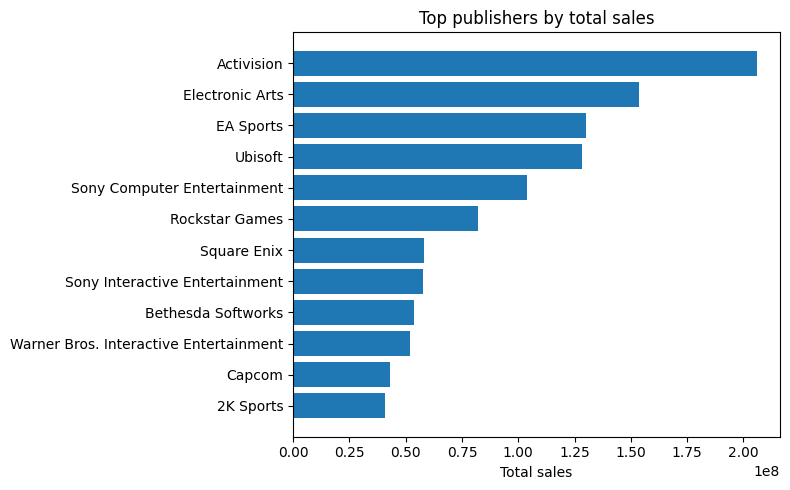

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('PlayStationSales.csv')

df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release Date'].dt.year
df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)

df['Console'] = df['Console'].astype(str)

rel = df.pivot_table(
    index='Year',
    columns='Console',
    values='Game',
    aggfunc='count'
).fillna(0).sort_index()

plt.figure(figsize=(10, 6))
for c in rel.columns:
    plt.plot(rel.index, rel[c], label=c)

plt.xlabel('Year')
plt.ylabel('Number of games')
plt.title('Releases per year by PlayStation generation')
plt.legend()
plt.tight_layout()
plt.show()

if 'Total Sales' in df.columns:
    sales_per_year = df.groupby('Year')['Total Sales'].sum().reset_index(name='TotalSales')

    plt.figure(figsize=(10, 5))
    plt.plot(sales_per_year['Year'], sales_per_year['TotalSales'])
    plt.xlabel('Year')
    plt.ylabel('Total sales')
    plt.title('Total sales per year')
    plt.tight_layout()
    plt.show()

top_pub = df.groupby('Publisher')['Total Sales'].sum().sort_values(ascending=False).head(12)

plt.figure(figsize=(8, 5))
plt.barh(top_pub.index[::-1], top_pub.values[::-1])
plt.xlabel('Total sales')
plt.title('Top publishers by total sales')
plt.tight_layout()
plt.show()


## **Step 3: Data Preparation**

---

### **Parse dates**
- Convert `Release Date` to a proper date type.
- Create a numeric `Year` column from `Release Date`.

### **Filter the usable time window**
- Keep only years where sales data is reliable (for example `2006–2018`, because after 2018 `Total Sales` is often zero or missing).

### **Handle missing values**
- Drop rows with missing `Release Date` or `Total Sales` if they cannot be used.
- Replace missing `Publisher` or `Developer` with `"Unknown"` or remove if needed.

### **Focus on PlayStation generations**
- Use only rows where `Console` is one of `PS3`, `PS4`, `PS5`.
- Optionally remove very rare or test entries.

### **Build analytic features**
- Create a `Series` or `Franchise` column from `Name` (group games that belong to the same series).
- Create a `Part` or `SequelOrder` column using `Name` and `Year` (Part 1, Part 2, etc.).
- Compute a **Series Performance Index** using `Total Sales`, normalized inside each `Console × Year` (for example z-score or percentile).

### **Prepare data for later steps**
- Create clean tables that will be reused for:
  - sequel delta analysis (Part `N+1` vs Part `N`),
  - generation jumps (`PS3 → PS4`, `PS4 → PS5`),
  - publisher stability over time.


In [2]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv('PlayStationSales.csv')

df = df_raw.copy()
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release Date'].dt.year

df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)

df = df[(df['Year'] >= 2006) & (df['Year'] <= 2018)]
df = df[df['Console'].isin(['PS3', 'PS4', 'PS5'])]

df['Publisher'] = df['Publisher'].fillna('Unknown')
df['TotalSales'] = df['Total Sales'].astype(float)

def extract_series(name):
    if not isinstance(name, str):
        return 'Unknown'
    base = name
    if ':' in base:
        base = base.split(':', 1)[0]
    if '-' in base:
        base = base.split('-', 1)[0]
    return base.strip()

df['Series'] = df['Name'].apply(extract_series)

df = df.sort_values(['Series', 'Year', 'Name'])
df['SequelOrder'] = df.groupby('Series')['Year'].rank(method='first').astype(int)

group_stats = df.groupby(['Console', 'Year'])['TotalSales'].agg(['mean', 'std']).reset_index()
group_stats = group_stats.rename(columns={'mean': 'mean_sales', 'std': 'std_sales'})
df = df.merge(group_stats, on=['Console', 'Year'], how='left')

def perf_index(row):
    if pd.isna(row['std_sales']) or row['std_sales'] == 0:
        return 0.0
    return (row['TotalSales'] - row['mean_sales']) / row['std_sales']

df['PerformanceIndex'] = df.apply(perf_index, axis=1)

prep_cols = ['Game', 'Name', 'Series', 'SequelOrder',
             'Console', 'Year', 'Publisher', 'TotalSales', 'PerformanceIndex']
df_prepared = df[prep_cols]

print(df_prepared.head())


                                    Game                               Name  \
0                    PS4_#killallzombies                    #killallzombies   
1  PS3_.hack: Sekai no Mukou ni + Versus  .hack: Sekai no Mukou ni + Versus   
2            PS4_.hack//G.U. Last Recode            .hack//G.U. Last Recode   
3             PS3_007: Quantum of Solace             007: Quantum of Solace   
4                        PS3_007 Legends                        007 Legends   

                    Series  SequelOrder Console  Year           Publisher  \
0          #killallzombies            1     PS4  2015         Beatshapers   
1                    .hack            1     PS3  2012  Namco Bandai Games   
2  .hack//G.U. Last Recode            1     PS4  2017  Namco Bandai Games   
3                      007            1     PS3  2008          Activision   
4              007 Legends            1     PS3  2012          Activision   

   TotalSales  PerformanceIndex  
0         0.0         -0.376

## **Step 4: Modelling**

---

### **Goal**
In this step we use the cleaned dataset to build simple models and analytical views that answer the main business questions:
- how sequels behave across PlayStation generations (`PS3`, `PS4`, `PS5`)
- how stable different `Publisher` portfolios are over time.

The focus is on **interpretable models**, not on complex machine learning.

### **Modelling approach**
We work on the prepared table `df_prepared` with columns such as:
`Game`, `Name`, `Series`, `SequelOrder`, `Console`, `Year`, `Publisher`, `TotalSales`, `PerformanceIndex`.

We apply three main modelling directions:

1. **Sequel performance model**
   - For each `Series`, we compare `PerformanceIndex` for `SequelOrder = 1`, `2`, `3`, etc.
   - We calculate **sequel deltas**:  
     `Delta = PerformanceIndex(Part N+1) − PerformanceIndex(Part N)`.
   - We summarise deltas for:
     - all sequels,
     - sequels that change generation (for example `PS3 → PS4`, `PS4 → PS5`),
     - sequels inside the same console.
   - The aim is to see if sequels tend to improve or decline and if generation jumps help or hurt performance.

2. **Generation comparison model**
   - We analyse `PerformanceIndex` by `Console` and `Year`.
   - We compute:
     - average and median `PerformanceIndex` per `Console`,
     - distribution of performance for each generation (for example boxplots or histograms).
   - This works as a simple **explanatory model**: does one generation (for example `PS4`) have systematically higher or lower performance compared to `PS3` and `PS5`?

3. **Publisher stability model**
   - For each `Publisher` we build a small time series of `PerformanceIndex` over `Year`.
   - We calculate stability metrics:
     - median `PerformanceIndex`,
     - spread (standard deviation or interquartile range) of `PerformanceIndex`,
     - number of games in the period.
   - We use these metrics to rank publishers:
     - **high median + low spread** = more stable and reliable portfolio,
     - **low median or very high spread** = more risky or inconsistent portfolio.

### **Type of models**
The modelling in this project is mainly:

- **Descriptive / explanatory**:
  - group statistics,
  - sequel deltas,
  - comparisons between consoles and years,
  - stability ranking by publisher.

- **Simple statistical modelling**, for example:
  - using `PerformanceIndex` as a target and checking how it changes with `Console`, `SequelOrder` and `Year`,
  - optional linear or ridge regression to see the direction and size of effects.

No complex prediction pipeline is required. The main goal is to support the business questions with clear, quantitative evidence.

### **Outputs from this step**
From this step we expect to obtain:

- Tables with sequel deltas, including separate views for generation jumps (`PS3 → PS4`, `PS4 → PS5`).
- Summary statistics of `PerformanceIndex` per `Console` and per `SequelOrder`.
- Stability table for publishers (median performance, spread, number of titles).
- Visualisations that show:
  - sequel behaviour over time,
  - performance distributions by generation,
  - publisher stability ranking.

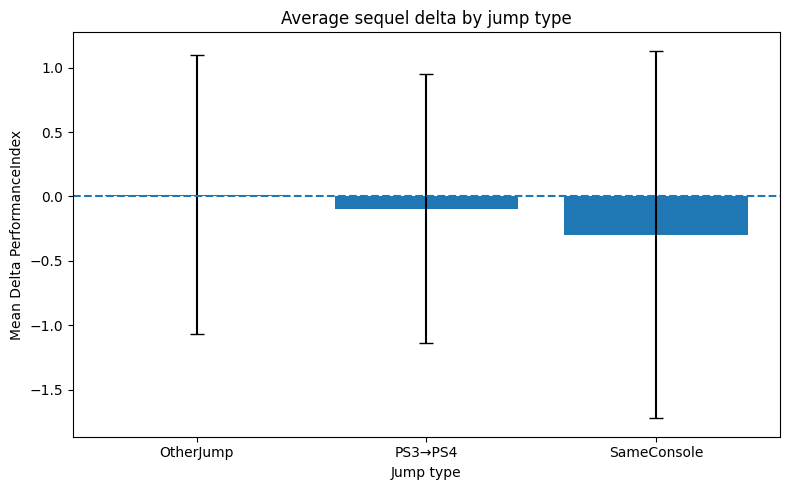

      JumpType  count      mean       std
0    OtherJump    205  0.013455  1.084436
1      PS3→PS4    177 -0.095816  1.044299
2  SameConsole    257 -0.295216  1.426761


<Figure size 800x500 with 0 Axes>

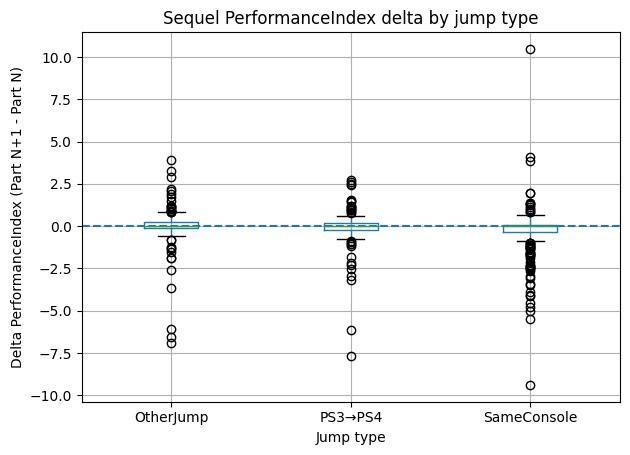


PerformanceIndex by console:
         count          mean    median       std
Console                                         
PS5          1  0.000000e+00  0.000000       NaN
PS3       1711  8.273141e-18 -0.267473  0.996485
PS4       1298  1.184637e-17 -0.270251  0.998071


<Figure size 800x500 with 0 Axes>

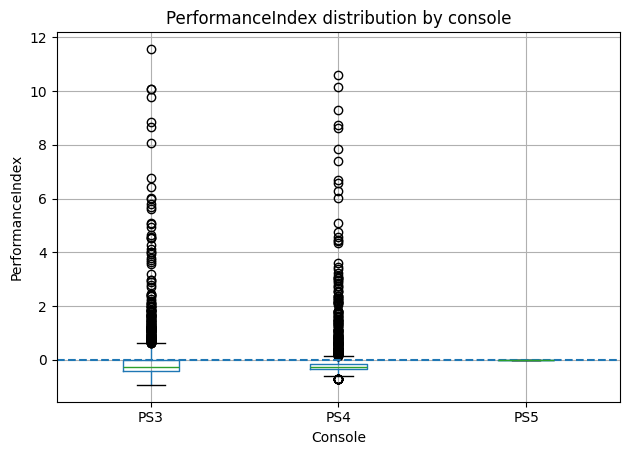


Top 10 stable publishers (by StabilityScore = MedianPI - StdPI, Games ≥ 5):
                            Games  MedianPI     StdPI  StabilityScore
Publisher                                                            
Milestone S.r.l.                7 -0.232806  0.033290       -0.266096
Outright Games                  5 -0.255273  0.025959       -0.281231
Wired Productions               5 -0.262762  0.034004       -0.296766
Entergram                       5 -0.270251  0.026666       -0.296917
Koei Tecmo                      5 -0.225317  0.079186       -0.304503
Idea Factory International      6 -0.253550  0.054447       -0.307997
Sold Out                        6 -0.251528  0.073710       -0.325238
Bandai Namco Entertainment     10 -0.210338  0.122175       -0.332514
Zen Studios                     5 -0.267473  0.065727       -0.333201
THQ Nordic                     23 -0.270251  0.066648       -0.336899


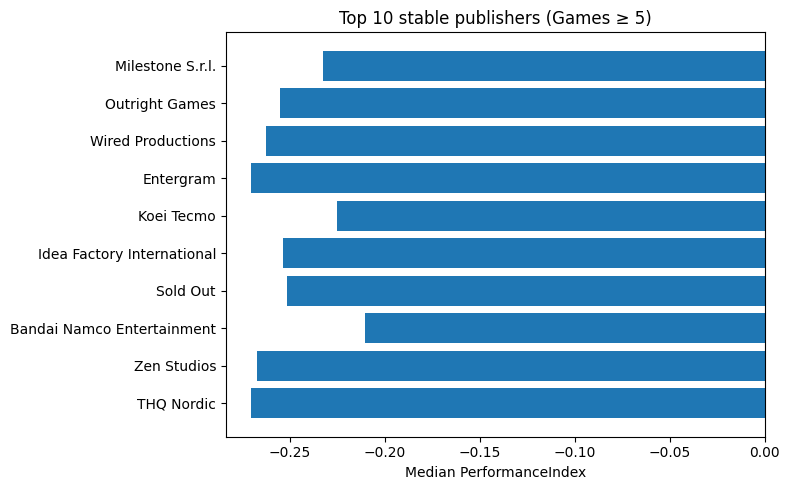

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

delta_stats = df_sequels.groupby('JumpType')['DeltaPI'].agg(['count', 'mean', 'std']).reset_index()

x = range(len(delta_stats))

plt.figure(figsize=(8, 5))
plt.bar(x, delta_stats['mean'], yerr=delta_stats['std'], capsize=5)
plt.axhline(0, linestyle='--')
plt.xticks(x, delta_stats['JumpType'])
plt.xlabel('Jump type')
plt.ylabel('Mean Delta PerformanceIndex')
plt.title('Average sequel delta by jump type')
plt.tight_layout()
plt.show()

print(delta_stats)

plt.figure(figsize=(8, 5))
df_sequels.boxplot(column='DeltaPI', by='JumpType')
plt.axhline(0, linestyle='--')
plt.title('Sequel PerformanceIndex delta by jump type')
plt.suptitle('')
plt.xlabel('Jump type')
plt.ylabel('Delta PerformanceIndex (Part N+1 - Part N)')
plt.tight_layout()
plt.show()

gen_stats = df_prepared.groupby('Console')['PerformanceIndex'].agg(['count', 'mean', 'median', 'std']).sort_values('median', ascending=False)
print("\nPerformanceIndex by console:")
print(gen_stats)

plt.figure(figsize=(8, 5))
df_prepared.boxplot(column='PerformanceIndex', by='Console')
plt.axhline(0, linestyle='--')
plt.title('PerformanceIndex distribution by console')
plt.suptitle('')
plt.xlabel('Console')
plt.ylabel('PerformanceIndex')
plt.tight_layout()
plt.show()

pub_stats = df_prepared.groupby('Publisher')['PerformanceIndex'].agg(['count', 'median', 'std'])
pub_stats = pub_stats.rename(columns={'count': 'Games', 'median': 'MedianPI', 'std': 'StdPI'})
pub_stats = pub_stats[pub_stats['Games'] >= 5].dropna(subset=['StdPI'])
pub_stats['StabilityScore'] = pub_stats['MedianPI'] - pub_stats['StdPI']
pub_stats_sorted = pub_stats.sort_values(['StabilityScore', 'MedianPI'], ascending=[False, False])

top_stable = pub_stats_sorted.head(10)
print("\nTop 10 stable publishers (by StabilityScore = MedianPI - StdPI, Games ≥ 5):")
print(top_stable[['Games', 'MedianPI', 'StdPI', 'StabilityScore']])

plt.figure(figsize=(8, 5))
plt.barh(top_stable.index[::-1], top_stable['MedianPI'][::-1])
plt.xlabel('Median PerformanceIndex')
plt.title('Top 10 stable publishers (Games ≥ 5)')
plt.tight_layout()
plt.show()
